In [112]:
import numpy as np
import random
from random import randint
from gurobipy import *
import pandas as pd
from random import seed
from two_weights import *
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.patches as mpatches

In [2]:
Manufacturing_plants = 2
Distribution = 3
Market = 4
Products = 2
Outsourced = 2
epsilon = 30

In [3]:
# Scenario parameters
a_si = [[1,1], [1,0], [0,1]] # don't include [0,0]
b_sj = [[1,1,1], [1,0,1], [1,1,0], [1,0,0], [0,1,1], [0,1,0], [0,0,1]] # don't include [0,0,0]

In [4]:
Scenarios = [[x,y] for x in a_si for y in b_sj]

In [5]:
Scenarios

[[[1, 1], [1, 1, 1]],
 [[1, 1], [1, 0, 1]],
 [[1, 1], [1, 1, 0]],
 [[1, 1], [1, 0, 0]],
 [[1, 1], [0, 1, 1]],
 [[1, 1], [0, 1, 0]],
 [[1, 1], [0, 0, 1]],
 [[1, 0], [1, 1, 1]],
 [[1, 0], [1, 0, 1]],
 [[1, 0], [1, 1, 0]],
 [[1, 0], [1, 0, 0]],
 [[1, 0], [0, 1, 1]],
 [[1, 0], [0, 1, 0]],
 [[1, 0], [0, 0, 1]],
 [[0, 1], [1, 1, 1]],
 [[0, 1], [1, 0, 1]],
 [[0, 1], [1, 1, 0]],
 [[0, 1], [1, 0, 0]],
 [[0, 1], [0, 1, 1]],
 [[0, 1], [0, 1, 0]],
 [[0, 1], [0, 0, 1]]]

In [6]:
num_Scenarios = len(Scenarios)
p_scen = 1/num_Scenarios

In [7]:
# Product Demand
demand = np.zeros((num_Scenarios, Products,Market))

In [8]:
distribution_mat = np.zeros((Products, Market,2))

In [9]:
distribution_mat[0][0][0] = 20
distribution_mat[0][1][0] = 25
distribution_mat[0][2][0] = 30
distribution_mat[0][3][0] = 35

distribution_mat[1][0][0] = 30
distribution_mat[1][1][0] = 35
distribution_mat[1][2][0] = 40
distribution_mat[1][3][0] = 45

distribution_mat[0][0][1] = 5
distribution_mat[0][1][1] = 3
distribution_mat[0][2][1] = 4
distribution_mat[0][3][1] = 2

distribution_mat[1][0][1] = 3
distribution_mat[1][1][1] = 4
distribution_mat[1][2][1] = 5
distribution_mat[1][3][1] = 6

In [10]:
distribution_mat

array([[[20.,  5.],
        [25.,  3.],
        [30.,  4.],
        [35.,  2.]],

       [[30.,  3.],
        [35.,  4.],
        [40.,  5.],
        [45.,  6.]]])

In [11]:
for s in range(num_Scenarios):
    for k in range(Market):
        for m in range(Products):
            demand[s][m][k] = np.round(np.random.normal(distribution_mat[m][k][0], distribution_mat[m][k][1]))

In [12]:
total_demand = np.sum(demand)

In [13]:
total_demand

5364.0

In [14]:
# Cost of opening
f_i = [200, 50]
f_j = [75, 100, 50]

In [15]:
# Unit cost of manufacturing product
np.random.seed(0)
Manufacturing_costs = np.random.uniform(0,2, (Manufacturing_plants,Products))

In [16]:
# Unit cost of transporting m from plant to DC
np.random.seed(0)
Transportation_i_j = np.random.uniform(0,2, (Products, Manufacturing_plants, Distribution))

In [17]:
# Unit cost of transporting m from DC to Market Zone
np.random.seed(0)
Transportation_j_k = np.random.uniform(0,2, (Products, Distribution, Market))

In [18]:
Transportation_j_k

array([[[1.09762701, 1.43037873, 1.20552675, 1.08976637],
        [0.8473096 , 1.29178823, 0.87517442, 1.783546  ],
        [1.92732552, 0.76688304, 1.58345008, 1.05778984]],

       [[1.13608912, 1.85119328, 0.14207212, 0.1742586 ],
        [0.04043679, 1.66523969, 1.5563135 , 1.7400243 ],
        [1.95723668, 1.59831713, 0.92295872, 1.56105835]]])

In [19]:
# Plant Capacities: Bigger capacities for the more expensive ones
np.random.seed(0)
Capacities_i = np.zeros(Manufacturing_plants) # in volume (metres cubed)
Capacities_i[0] = np.random.randint(800,1000)
Capacities_i[1] = np.random.randint(200,400) 
Capacities_j = np.zeros(Distribution) # in volume (metres cubed)
Capacities_j[0] = np.random.randint(400, 600)
Capacities_j[1] = np.random.randint(600, 800)
Capacities_j[2] = np.random.randint(200,400)
Capacities_l = np.random.randint(50,100, (Products,Outsourced)) # in terms of products 

In [20]:
# Cost of purchasing product m from supplier l 
np.random.seed(0)
levels = 2
Supplier_cost = np.zeros((levels, Products, Outsourced))
Supplier_cost[0] = np.random.uniform(15, 20, (Products, Outsourced))
Supplier_cost[1] = np.random.randint(20, 25, (Products, Outsourced))

In [21]:
Supplier_cost

array([[[17.74406752, 18.57594683],
        [18.01381688, 17.72441591]],

       [[21.        , 23.        ],
        [22.        , 24.        ]]])

In [22]:
# Cost of transporting product m from outsourced facility l to j
np.random.seed(0)
T_O_DC = np.random.uniform(2, 5, (Products, Outsourced, Distribution))

In [23]:
# Cost of shipping product m from outsourced facility l to k
np.random.seed(0)
T_O_MZ = np.random.uniform(5, 7,(Products, Outsourced, Market))

In [24]:
# Product volume 
np.random.seed(0)
volume = np.random.uniform(2,3,(Products))

In [25]:
# unit cost of lost sales 
np.random.seed(40)
lost_sales = np.random.randint(18, 25,(Market,Products))

In [26]:
lost_sales

array([[24, 21],
       [23, 18],
       [18, 20],
       [19, 22]])

In [27]:
# Initialize model variables
x_i = {} # opening manufacturing plant
x_j = {} # opening DC
U_km = {} # quantity lost sales
V_lm = {} # quantity products purchased from outsourcing
Q_im = {} # quantity produced
Y_ijm = {} # shipping i -> j
Z_jkm = {} # shipping j -> k
T_ljm = {} # shipping l -> j
T_lkm = {} # shipping l -> k
y_lm = {} # indicator variable for step function 

# Dictionaries for analysis 
Cost_dict = {}
Summary_dict = {}
#recovered_demand = np.zeros((num_Scenarios, Products,Market))

## Deterministic Model

In [28]:
grbModel_det = Model('deterministic') # to obtain obj val of each scenario

Using license file C:\Users\Devika Kabe\gurobi.lic
Academic license - for non-commercial use only


In [29]:
def SetGurobiModel(scen):
    
    for i in range(Manufacturing_plants):
        x_i[i] = grbModel_det.addVar(vtype = GRB.BINARY)
    
    for j in range(Distribution):
        x_j[j] = grbModel_det.addVar(vtype = GRB.BINARY)
    
    for k in range(Market):
        for m in range(Products):
            U_km[k,m] = grbModel_det.addVar(vtype = GRB.INTEGER)
        
    for m in range(Products):
        for l in range(Outsourced):
            V_lm[m,l] = grbModel_det.addVar(vtype = GRB.INTEGER)
    
    for m in range(Products):
        for i in range(Manufacturing_plants):
            Q_im[m,i] = grbModel_det.addVar(vtype = GRB.INTEGER)
            
    for m in range(Products):
        for i in range(Manufacturing_plants):
            for j in range(Distribution):
                Y_ijm[m,i,j] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for j in range(Distribution):
            for k in range(Market): 
                Z_jkm[m,j,k] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for l in range(Outsourced):
            for j in range(Distribution):
                T_ljm[m,l,j] = grbModel_det.addVar(vtype = GRB.INTEGER)      
    
    for m in range(Products):
        for l in range(Outsourced):
            for k in range(Market):
                T_lkm[m,l,k] = grbModel_det.addVar(vtype = GRB.INTEGER)                
    
    for m in range(Products):
        for l in range(Outsourced):
            y_lm[m,l] = grbModel_det.addVar(vtype = GRB.BINARY)
                
    SetGrb_Obj()
    ModelCons(scen)


In [30]:
def SolveModel(scen):
    
    grbModel_det.params.OutputFlag = 0
    grbModel_det.optimize()
    
    # get variable values 
    v_val_x_i = grbModel_det.getAttr('x', x_i)
    v_val_x_j = grbModel_det.getAttr('x', x_j)
    v_val_U_km = grbModel_det.getAttr('x', U_km)
    v_val_V_lm = grbModel_det.getAttr('x', V_lm)
    v_val_Q_im = grbModel_det.getAttr('x', Q_im)
    v_val_Y_ijm = grbModel_det.getAttr('x', Y_ijm)
    v_val_Z_jkm = grbModel_det.getAttr('x', Z_jkm)
    v_val_T_ljm = grbModel_det.getAttr('x', T_ljm)
    v_val_T_lkm = grbModel_det.getAttr('x', T_lkm)
    v_val_y_lm = grbModel_det.getAttr('x', y_lm)    
    
    obj = grbModel_det.getObjective()
        
    return


In [31]:
# Objective

def SetGrb_Obj():

    grb_expr = LinExpr()

    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x_i[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x_j[j]    
        
    # Shipment 
    ship_1 = 0
    ship_2 = 0
    ship_3 = 0
    ship_4 = 0
    
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            for m in range(Products):
                ship_1 += Transportation_i_j[m][i][j]*Y_ijm[m,i,j]

    for j in range(Distribution):
        for k in range(Market):
            for m in range(Products):
                ship_2 += Transportation_j_k[m][j][k]*Z_jkm[m,j,k]

    for l in range(Outsourced):
        for j in range(Distribution):
            for m in range(Products):
                ship_3 += T_O_DC[m][l][j]*T_ljm[m,l,j]

    for l in range(Outsourced):
        for k in range(Market):
            for m in range(Products):
                ship_4 += T_O_MZ[m][l][k]*T_lkm[m,l,k]
                    
    total_shipment = ship_1 + ship_2 + ship_3 + ship_4

    # Production
    pr_cost = 0
    for i in range(Manufacturing_plants):
        for m in range(Products):
            pr_cost += Manufacturing_costs[i][m]*Q_im[m,i]                

    # Buying from outsource cost
    b_cost = 0
    for l in range(Outsourced):
        for m in range(Products):
            b_cost += Supplier_cost[0][m][l]*V_lm[m,l]*(1 - y_lm[m,l]) + (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[m,l] - epsilon))*y_lm[m,l]

    #Lost Sales
    l_cost = 0
    for k in range(Market):
        for m in range(Products):
            l_cost += lost_sales[k][m]*U_km[k,m]                

    grb_expr += OC_1 + OC_2 + total_shipment + pr_cost + b_cost + l_cost
    
    grbModel_det.setObjective(grb_expr, GRB.MINIMIZE)
    
    return 

In [32]:
# Model Constraints

def ModelCons(scen):
    
    # Network Flow

    grbModel_det.addConstrs(Q_im[m,i] >= quicksum(Y_ijm[m,i,j] for j in range(Distribution)) 
                         for i in range(Manufacturing_plants) for m in range(Products))

    grbModel_det.addConstrs((quicksum(Y_ijm[m,i,j] for i in range(Manufacturing_plants)) +
                         quicksum(T_ljm[m,l,j] for l in range(Outsourced))) >= quicksum(Z_jkm[m,j,k] for k in range(Market))                        
                        for j in range(Distribution) for m in range(Products))

    grbModel_det.addConstrs((quicksum(Z_jkm[m,j,k] for j in range(Distribution)) +
                         quicksum(T_lkm[m,l,k] for l in range(Outsourced)) + U_km[k,m]) >= demand[s][m][k]
                         for k in range(Market) for m in range(Products))  
        
                    
    # Purchasing Constraints (everything purchased from outsourced facilities must be shipped)
    grbModel_det.addConstrs(V_lm[m,l] >= quicksum(T_ljm[m,l,j] for j in range(Distribution)) + 
                        quicksum(T_lkm[m,l,k] for k in range(Market))  
                        for m in range(Products) for l in range(Outsourced))
    
    
    # Capacity Constraints
    grbModel_det.addConstrs(quicksum(volume[m]*Q_im[m,i] for m in range(Products)) <= Scenarios[scen][0][i]*Capacities_i[i]*x_i[i] 
                         for i in range(Manufacturing_plants))
    
    grbModel_det.addConstrs(quicksum(volume[m]*Y_ijm[m,i,j] for i in range(Manufacturing_plants) for m in range(Products)) +
                        quicksum(volume[m]*T_ljm[m,l,j] for l in range(Outsourced) for m in range(Products)) <= 
                        Scenarios[scen][1][j]*Capacities_j[j]*x_j[j]  
                        for j in range(Distribution))
    
    grbModel_det.addConstrs((V_lm[m,l] <= (Capacities_l[m][l])) 
                        for l in range(Outsourced) for m in range(Products))
    
    
    # Indicator variable constraints for step function (25 is arbitrary)
    grbModel_det.addConstrs(V_lm[m,l] >= (epsilon + 1)*y_lm[m,l] for m in range(Products) for l in range(Outsourced))
    grbModel_det.addConstrs((V_lm[m,l] - (Capacities_l[m][l] - epsilon)*y_lm[m,l]) <= epsilon 
                               for m in range(Products) for l in range(Outsourced))
    
    return

In [33]:
def run_Model(scen):    
        
    SetGurobiModel(scen)
    SolveModel(scen)

In [34]:
scen_objs = []

In [35]:
for s in range(num_Scenarios):
    x_i = {} # opening manufacturing plant
    x_j = {} # opening DC
    U_km = {} # quantity lost sales
    V_lm = {} # quantity products purchased from outsourcing
    Q_im = {} # quantity produced
    Y_ijm = {} # shipping i -> j
    Z_jkm = {} # shipping j -> k
    T_ljm = {} # shipping l -> j
    T_lkm = {} # shipping l -> k
    y_lm = {} # indicator variable for step function 
    run_Model(s)
    scen_objs += [np.round(grbModel_det.objval,2)]

In [36]:
scen_objs

[1087.03,
 1139.71,
 1273.07,
 2030.17,
 1283.18,
 1339.74,
 3385.39,
 1140.74,
 1050.77,
 1225.38,
 1723.5,
 1375.13,
 1375.62,
 3897.58,
 3594.13,
 3764.78,
 3644.82,
 3479.66,
 3497.33,
 3470.98,
 3483.83]

In [37]:
penalty_weights = [scen_objs[0]/scen_objs[i] for i in range(num_Scenarios)]

In [38]:
penalty_weights = [500]*num_Scenarios

In [39]:
penalty_weights

[500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500,
 500]

## Stochastic Model

In [40]:
# Initialize model variables
x_i = {} # opening manufacturing plant
x_j = {} # opening DC
U_km = {} # quantity lost sales
V_lm = {} # quantity products purchased from outsourcing
Q_im = {} # quantity produced
Y_ijm = {} # shipping i -> j
Z_jkm = {} # shipping j -> k
T_ljm = {} # shipping l -> j
T_lkm = {} # shipping l -> k
y_lm = {} # indicator variable for step function 
delta_s = {} # penalty for p-robust
w_s = {} # reward for meeting demand above specified rate

# Dictionaries for analysis 
Cost_dict = {}
Summary_dict = {}

# Dictionary to weigh different objectives 
objWeights = {} 

# Dictionary to save values of each objectives
dic_grbOut = {}

In [41]:
grbModel = Model('stochastic')

In [42]:
def SetGurobiModel(p, rl):
    
    for i in range(Manufacturing_plants):
        x_i[i] = grbModel.addVar(vtype = GRB.BINARY)
    
    for j in range(Distribution):
        x_j[j] = grbModel.addVar(vtype = GRB.BINARY)
    
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                U_km[s,k,m] = grbModel.addVar(vtype = GRB.CONTINUOUS)
        
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                V_lm[s,m,l] = grbModel.addVar(vtype = GRB.CONTINUOUS)
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for i in range(Manufacturing_plants):
                Q_im[s,m,i] = grbModel.addVar(vtype = GRB.CONTINUOUS)
            
    for s in range(num_Scenarios):  
        for m in range(Products):
            for i in range(Manufacturing_plants):
                for j in range(Distribution):
                    Y_ijm[s,m,i,j] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for j in range(Distribution):
                for k in range(Market): 
                    Z_jkm[s,m,j,k] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                for j in range(Distribution):
                    T_ljm[s,m,l,j] = grbModel.addVar(vtype = GRB.CONTINUOUS)      
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                for k in range(Market):
                    T_lkm[s,m,l,k] = grbModel.addVar(vtype = GRB.CONTINUOUS)                
    
    for s in range(num_Scenarios):
        for m in range(Products):
            for l in range(Outsourced):
                y_lm[s,m,l] = grbModel.addVar(vtype = GRB.BINARY)
                
    for s in range(num_Scenarios):
        delta_s[s] = grbModel.addVar(vtype = GRB.CONTINUOUS)
        
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                w_s[s,k,m] = grbModel.addVar(vtype = GRB.BINARY)
                
    SetGrb_Obj()
    ModelCons(p, rl)

In [43]:
def SolveModel():
    
    grbModel.params.OutputFlag = 0
    grbModel.optimize()
    
    # get variable values 
    v_val_x_i = grbModel.getAttr('x', x_i)
    v_val_x_j = grbModel.getAttr('x', x_j)
    v_val_U_km = grbModel.getAttr('x', U_km)
    v_val_V_lm = grbModel.getAttr('x', V_lm)
    v_val_Q_im = grbModel.getAttr('x', Q_im)
    v_val_Y_ijm = grbModel.getAttr('x', Y_ijm)
    v_val_Z_jkm = grbModel.getAttr('x', Z_jkm)
    v_val_T_ljm = grbModel.getAttr('x', T_ljm)
    v_val_T_lkm = grbModel.getAttr('x', T_lkm)
    v_val_y_lm = grbModel.getAttr('x', y_lm)
    v_val_delta_s = grbModel.getAttr('x', delta_s)
    v_val_w = grbModel.getAttr('x', w_s)
    
    obj = grbModel.getObjective()
    print("obj val: ", obj.getValue())   
    
    Summary_dict['ObjVal'] = grbModel.objval
    Summary_dict["OpenMPs"] = np.sum(v_val_x_i.values())
    Summary_dict["OpenDCs"] = np.sum(v_val_x_j.values())
    Cost_dict["Opening"] =  get_opening_costs(v_val_x_i, v_val_x_j)
    Cost_dict["pr_Penalties"] = np.round(p_scen*get_pr_penalty_costs(v_val_delta_s), 2)
    Cost_dict["f2"] = np.round(p_scen*get_rl_rate(v_val_w))
    
    for s in range(num_Scenarios):        
        Summary_dict["Purchasing_" + str(s)] = sum([v_val_V_lm[(s,m,l)] for m in range(Products) for l in range(Outsourced)])    
        Summary_dict["Production_" + str(s)] = sum([v_val_Q_im[(s,m,i)] for m in range(Products) for i in range(Manufacturing_plants)])
        Summary_dict["LostSales_" + str(s)] = sum([v_val_U_km[(s,k,m)] for m in range(Products) for k in range(Market)])
        Summary_dict["OutsourceToDC_" + str(s)] = sum([v_val_T_ljm[(s,m,l,j)] for m in range(Products) for l in range(Outsourced) for j in range(Distribution)])
        Summary_dict["OutsourceToMarket_" + str(s)] = sum([v_val_T_lkm[(s,m,l,k)] for m in range(Products) for l in range(Outsourced) for k in range(Market)])        
        
    for s in range(num_Scenarios):
        Cost_dict["InHouseShipping_" + str(s)] = get_shipping_costs(s,v_val_Y_ijm, v_val_Z_jkm, v_val_T_ljm, v_val_T_lkm)[0]
        Cost_dict["OutsourceShipping_" + str(s)] = get_shipping_costs(s,v_val_Y_ijm, v_val_Z_jkm, v_val_T_ljm, v_val_T_lkm)[1]
        Cost_dict["Production_" + str(s)] = get_production_cost(s,v_val_Q_im)
        Cost_dict["Purchasing_" + str(s)] = get_purchase_costs(s,v_val_V_lm, v_val_y_lm)
        Cost_dict["LostSales_" + str(s)] = get_lost_cost(s,v_val_U_km)
    
    Purchasing_cost = np.sum([Cost_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)])
    Production_cost = np.sum([Cost_dict['Production_' + str(s)] for s in range(num_Scenarios)])
    LostSales_cost = np.sum([Cost_dict['LostSales_' + str(s)] for s in range(num_Scenarios)])
    InHouseShipping = np.sum([Cost_dict['InHouseShipping_' + str(s)] for s in range(num_Scenarios)])
    OutsourceShipping = np.sum([Cost_dict['OutsourceShipping_' + str(s)] for s in range(num_Scenarios)])
    
    Cost_dict["f1"] = np.round(Cost_dict["Opening"] + p_scen*(Purchasing_cost + Production_cost + LostSales_cost + InHouseShipping + OutsourceShipping) + Cost_dict['pr_Penalties'], 2)

    return

In [44]:
# Objective

def SetGrb_Obj():

    grb_expr = LinExpr()

    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x_i[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x_j[j]       
    
    total_shipment = 0    
    total_pr_cost = 0
    total_b_cost = 0
    total_l_cost = 0
    
    # Shipment 

    for s in range(num_Scenarios):
        ship_1 = 0
        ship_2 = 0
        ship_3 = 0
        ship_4 = 0
        for i in range(Manufacturing_plants):
            for j in range(Distribution):
                for m in range(Products):
                    ship_1 += Transportation_i_j[m][i][j]*Y_ijm[s,m,i,j]

        for j in range(Distribution):
            for k in range(Market):
                for m in range(Products):
                    ship_2 += Transportation_j_k[m][j][k]*Z_jkm[s,m,j,k]

        for l in range(Outsourced):
            for j in range(Distribution):
                for m in range(Products):
                    ship_3 += T_O_DC[m][l][j]*T_ljm[s,m,l,j]

        for l in range(Outsourced):
            for k in range(Market):
                for m in range(Products):
                    ship_4 += T_O_MZ[m][l][k]*T_lkm[s,m,l,k]
                    
        total_shipment += ship_1 + ship_2 + ship_3 + ship_4

        # Production
        pr_cost = 0
        for i in range(Manufacturing_plants):
            for m in range(Products):
                pr_cost += Manufacturing_costs[i][m]*Q_im[s,m,i]
                
        total_pr_cost += pr_cost

        # Buying from outsource cost
        b_cost = 0
        for l in range(Outsourced):
            for m in range(Products):
                b_cost += Supplier_cost[0][m][l]*V_lm[s,m,l]*(1 - y_lm[s,m,l]) + \
                (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[s,m,l] - epsilon))*y_lm[s,m,l]
                
        total_b_cost += b_cost

        #Lost Sales
        l_cost = 0
        for k in range(Market):
            for m in range(Products):
                l_cost += lost_sales[k][m]*U_km[s,k,m]
                
        total_l_cost += l_cost   

    # Penalties
    p_robust_penalties = 0
    for s in range(num_Scenarios):
        p_robust_penalties += penalty_weights[s]*delta_s[s]    
        
    
    # Percentage of demand met
    rl_penalty = 0
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                rl_penalty += lost_sales[k][m]*w_s[s,k,m]*demand[s][m][k]       
    
    grb_expr += objWeights['f1']*(OC_1 + OC_2 + p_scen*(total_shipment + total_pr_cost + total_b_cost + total_l_cost) + \
  p_scen*p_robust_penalties) + objWeights['f2']*p_scen*rl_penalty

    
    grbModel.setObjective(grb_expr, GRB.MINIMIZE)
    
    return 


In [45]:
# Model Constraints

def ModelCons(p, rl):
    
    # Network Flow

    grbModel.addConstrs(Q_im[s,m,i] >= quicksum(Y_ijm[s,m,i,j] for j in range(Distribution)) 
                         for s in range(num_Scenarios) for i in range(Manufacturing_plants) for m in range(Products))

    grbModel.addConstrs((quicksum(Y_ijm[s,m,i,j] for i in range(Manufacturing_plants)) +
                         quicksum(T_ljm[s,m,l,j] for l in range(Outsourced))) >= quicksum(Z_jkm[s,m,j,k] for k in range(Market))                        
                        for s in range(num_Scenarios) for j in range(Distribution) for m in range(Products))
    
    grbModel.addConstrs(quicksum(Z_jkm[s,m,j,k] for j in range(Distribution)) + 
                        quicksum(T_lkm[s,m,l,k] for l in range(Outsourced)) + 
                        U_km[s,k,m] >= demand[s][m][k] for s in range(num_Scenarios) for m in range(Products)
                        for k in range(Market))
    
    #grbModel.addConstrs(quicksum(Z_jkm[s,m,j,k] for j in range(Distribution)) + 
     #                   quicksum(T_lkm[s,m,l,k] for l in range(Outsourced)) <= demand[s][m][k] for s in range(num_Scenarios) for m in range(Products)
      #                  for k in range(Market))
        
                    
    # Purchasing Constraints (everything purchased from outsourced facilities must be shipped)
    grbModel.addConstrs(V_lm[s,m,l] >= quicksum(T_ljm[s,m,l,j] for j in range(Distribution)) + 
                        quicksum(T_lkm[s,m,l,k] for k in range(Market)) for s in range(num_Scenarios) 
                        for m in range(Products) for l in range(Outsourced))
    
    # Purchasing Constraints (can only outsource in disruption)
        
    # Capacity Constraints
    grbModel.addConstrs(quicksum(volume[m]*Q_im[s,m,i] for m in range(Products)) <= Scenarios[s][0][i]*Capacities_i[i]*x_i[i] 
                        for s in range(num_Scenarios) for i in range(Manufacturing_plants))
    
    grbModel.addConstrs(quicksum(volume[m]*Y_ijm[s,m,i,j] for i in range(Manufacturing_plants) for m in range(Products)) +
                        quicksum(volume[m]*T_ljm[s,m,l,j] for l in range(Outsourced) for m in range(Products)) <= 
                        Scenarios[s][1][j]*Capacities_j[j]*x_j[j] for s in range(num_Scenarios) for s in range(num_Scenarios)
                        for j in range(Distribution))
    
    grbModel.addConstrs((V_lm[s,m,l] <= (Capacities_l[m][l])) for s in range(num_Scenarios)
                        for l in range(Outsourced) for m in range(Products))
    
    
    # Indicator variable constraints for step function (25 is arbitrary)
    grbModel.addConstrs(V_lm[s,m,l] >= (epsilon + 1)*y_lm[s,m,l] for s in range(num_Scenarios) 
                        for m in range(Products) for l in range(Outsourced))
    
    grbModel.addConstrs((V_lm[s,m,l] - (Capacities_l[m][l] - epsilon)*y_lm[s,m,l])
                         <= epsilon for s in range(num_Scenarios) for m in range(Products) for l in range(Outsourced))   
    
    
    #Demand Metric (w = 1 if demand met is below rl)
    grbModel.addConstrs((U_km[s,k,m]/demand[s][m][k]) - (rl + 0.0001)*w_s[s,k,m] <= 1 - rl - 0.0001
                        for s in range(num_Scenarios) for k in range(Market) for m in range(Products))    

    
    #P-robust metric    
    grbModel.addConstrs(quicksum(f_i[i]*x_i[i] for i in range(Manufacturing_plants))
                        + quicksum(f_j[j]*x_j[j] for j in range(Distribution))
                        + quicksum(Transportation_i_j[m][i][j]*Y_ijm[s,m,i,j] for i in range(Manufacturing_plants) 
                                  for j in range(Distribution) for m in range(Products))
                        + quicksum(Transportation_j_k[m][j][k]*Z_jkm[s,m,j,k] for j in range(Distribution)
                                   for k in range(Market) for m in range(Products))
                        + quicksum(T_O_DC[m][l][j]*T_ljm[s,m,l,j] for l in range(Outsourced) for j in range(Distribution)
                                   for m in range(Products))
                        + quicksum(T_O_MZ[m][l][k]*T_lkm[s,m,l,k] for l in range(Outsourced) for k in range(Market)
                                   for m in range(Products))
                        + quicksum(Manufacturing_costs[i][m]*Q_im[s,m,i] for i in range(Manufacturing_plants) 
                                   for m in range(Products))
                        + quicksum(Supplier_cost[0][m][l]*V_lm[s,m,l]*(1 - y_lm[s,m,l]) + \
                (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V_lm[s,m,l] - epsilon))*y_lm[s,m,l]
                                   for l in range(Outsourced) for m in range(Products))
                        + quicksum(lost_sales[k][m]*U_km[s,k,m] for k in range(Market) for m in range(Products)) - delta_s[s]
                        
                        <= (1 + p)*scen_objs[s] for s in range(num_Scenarios))                                 
                                                                    
    
    return   


In [46]:
def get_opening_costs(x1, x2):
    
    # Cost of opening
    OC_1 = 0
    OC_2 = 0
    for i in range(Manufacturing_plants):
        OC_1 += f_i[i]*x1[i]
    for j in range(Distribution):
        OC_2 += f_j[j]*x2[j]

    Opening = np.round(OC_1 + OC_2)
    
    return(Opening)
   
def get_shipping_costs(scen, Y, Z, T1, T2):
    ship_1 = 0
    ship_2 = 0
    ship_3 = 0
    ship_4 = 0

    # Shipment
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            for m in range(Products):
                ship_1 += Transportation_i_j[m][i][j]*Y[scen, m,i,j]

    for j in range(Distribution):
        for k in range(Market):
            for m in range(Products):
                ship_2 += Transportation_j_k[m][j][k]*Z[scen,m,j,k]

    for l in range(Outsourced):
        for j in range(Distribution):
            for m in range(Products):
                ship_3 += T_O_DC[m][l][j]*T1[scen,m,l,j]

    for l in range(Outsourced):
        for k in range(Market):
            for m in range(Products):
                ship_4 += T_O_MZ[m][l][k]*T2[scen,m,l,k]
    
    in_house_shipping = np.round(ship_1 + ship_2)

    outsourced_shipping = np.round(ship_3 + ship_4)
    
    return(in_house_shipping, outsourced_shipping)

def get_production_cost(scen, Q):

    # Production
    pr_cost = 0
    for i in range(Manufacturing_plants):
        for m in range(Products):
            pr_cost += Manufacturing_costs[i][m]*Q[scen,m,i]
            
    return(np.round(pr_cost))

def get_purchase_costs(scen, V, y):    

    # Buying from outsource cost
    b_cost = 0
    for l in range(Outsourced):
        for m in range(Products):
            b_cost += Supplier_cost[0][m][l]*V[scen,m,l]*(1 - y[scen,m,l]) + (Supplier_cost[0][m][l]*epsilon + Supplier_cost[1][m][l]*(V[scen,m,l] - epsilon))*y[scen,m,l]          

    return(np.round(b_cost))

def get_lost_cost(scen,U):
    
    #Lost Sales
    l_cost = 0
    for k in range(Market):
        for m in range(Products):
            l_cost += lost_sales[k][m]*U[scen,k,m]
            
    return(np.round(l_cost))

def get_pr_penalty_costs(delta):
    penalties = 0
    for s in range(num_Scenarios):
        penalties += penalty_weights[s]*delta[s]
    return(penalties)

def get_rl_rate(w):
    rl_penalty = 0
    for s in range(num_Scenarios):
        for k in range(Market):
            for m in range(Products):
                rl_penalty += lost_sales[k][m]*w[s,k,m]*demand[s][m][k]    
    
    return(rl_penalty)

In [47]:
def run_Model(p, rl, objDict):
    for key, value in objDict.items():
        objWeights[key] = value
        
    SetGurobiModel(p, rl)
    SolveModel()

In [48]:
def dict_to_dataframe(Dict):
    return pd.DataFrame([list(Dict.values())], columns = list(Dict.keys()))

In [49]:
run_Model(0.4, 0.95, {'f1': 1, 'f2': 1})

obj val:  2846.314174347336


In [50]:
num_correct = 0
for s in range(num_Scenarios):
    if np.round((Summary_dict['Purchasing_'+str(s)] + Summary_dict['Production_' + str(s) ] + Summary_dict['LostSales_' + str(s)])) == np.sum(demand[s]):
        num_correct += 1
    else:
        print (np.round(Summary_dict['Purchasing_'+str(s)] + Summary_dict['Production_' + str(s) ] + Summary_dict['LostSales_' + str(s)]))
        print(np.sum(demand[s]))
        (print(s))
    
num_correct == num_Scenarios

True

In [51]:
num_correct

21

In [52]:
Purchasing = [Summary_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)]
Production = [Summary_dict['Production_' + str(s)] for s in range(num_Scenarios)]
LostSales = [Summary_dict['LostSales_' + str(s)] for s in range(num_Scenarios)]
OutsourceToDC = [Summary_dict['OutsourceToDC_' + str(s)] for s in range(num_Scenarios)]
OutsourceToMarket = [Summary_dict['OutsourceToMarket_' + str(s)] for s in range(num_Scenarios)]

In [53]:
Unit_df = pd.DataFrame(list(zip(Purchasing, Production, LostSales, OutsourceToDC, OutsourceToMarket)), 
             columns = ["Purchasing", "Production", "LostSales", "OutsourceToDC", "OutsourceToMarket"])

In [54]:
np.round(Unit_df)

,Purchasing,Production,LostSales,OutsourceToDC,OutsourceToMarket
0,0.0,243.0,0.0,0.0,0.0
1,0.0,255.0,0.0,0.0,0.0
2,0.0,281.0,0.0,0.0,0.0
3,55.0,196.0,9.0,0.0,55.0
4,0.0,245.0,0.0,0.0,0.0
5,0.0,249.0,0.0,0.0,0.0
6,133.0,101.0,12.0,0.0,133.0
7,0.0,257.0,0.0,0.0,0.0
8,0.0,232.0,0.0,0.0,0.0
9,0.0,265.0,0.0,0.0,0.0


In [55]:
Scen_demand = 1 - np.array(list(Unit_df['LostSales']))/(np.array(list(Unit_df['Purchasing'])) + np.array(list(Unit_df['Production'])) + (np.array(list(Unit_df['LostSales']))))

In [56]:
Purchasing_cost = [Cost_dict['Purchasing_' + str(s)] for s in range(num_Scenarios)]
Production_cost = [Cost_dict['Production_' + str(s)] for s in range(num_Scenarios)]
LostSales_cost = [Cost_dict['LostSales_' + str(s)] for s in range(num_Scenarios)]
InHouseShipping = [Cost_dict['InHouseShipping_' + str(s)] for s in range(num_Scenarios)]
OutsourceShipping = [Cost_dict['OutsourceShipping_' + str(s)] for s in range(num_Scenarios)]

In [57]:
Cost_dict['f1'] + Cost_dict['f2']

2846.14

In [58]:
grbModel.objVal

2846.314174347331

In [59]:
Cost_df = pd.DataFrame(list(zip(Purchasing_cost, Production_cost, LostSales_cost, InHouseShipping, OutsourceShipping)), 
             columns = ["Purchasing", "Production", "LostSales", "InHouseShipping", "OutsourceShipping"])

In [60]:
Cost_df

,Purchasing,Production,LostSales,InHouseShipping,OutsourceShipping
0,0.0,293.0,0.0,418.0,0.0
1,0.0,300.0,0.0,469.0,0.0
2,0.0,355.0,0.0,496.0,0.0
3,1001.0,219.0,165.0,338.0,329.0
4,0.0,283.0,0.0,600.0,0.0
5,0.0,289.0,0.0,702.0,0.0
6,2519.0,111.0,251.0,233.0,762.0
7,0.0,332.0,0.0,472.0,0.0
8,0.0,303.0,0.0,423.0,0.0
9,0.0,342.0,0.0,508.0,0.0


In [61]:
Summary_dict["OpenMPs"]

2.0

In [62]:
Summary_dict["OpenDCs"]

3.0

In [63]:
scen_costs = [Cost_dict['Opening'] + Purchasing_cost[s] + Production_cost[s] + InHouseShipping[s] + OutsourceShipping[s] + LostSales_cost[s] for s in range(num_Scenarios)]

In [64]:
(np.array(scen_costs) - np.array(scen_objs))/np.array(scen_objs)

array([0.09104625, 0.09150573, 0.04157666, 0.24472335, 0.05830827,
       0.09424217, 0.28522859, 0.12120203, 0.14297134, 0.08129723,
       0.25210328, 0.09080596, 0.1274916 , 0.28028161, 0.27624766,
       0.29011523, 0.2755088 , 0.29782795, 0.29527382, 0.30136158,
       0.33502496])

In [65]:
Cost_dict['f1']

2846.14

In [66]:
Cost_dict['f2']

0.0

In [67]:
Cost_dict['pr_Penalties']

0.0

## Heat Maps

In [68]:
U = grbModel.getAttr('x',U_km)

In [69]:
U_km_mat = np.zeros((num_Scenarios, Products, Market))

In [70]:
for s in range(num_Scenarios):
    for k in range(Market):
        for m in range(Products):
            U_km_mat[s][m][k] = U[s,k,m]

In [71]:
s_lostSales = sum(U_km_mat)

In [72]:
s_Demand = sum(demand)

In [73]:
s_Demand

array([[428., 504., 633., 736.],
       [621., 703., 831., 908.]])

In [74]:
demand_met = 1 - s_lostSales/s_Demand

In [75]:
demand_met

array([[0.97808131, 0.97821825, 0.9735128 , 0.97346872],
       [0.97613478, 0.97487255, 0.97628099, 0.97785275]])

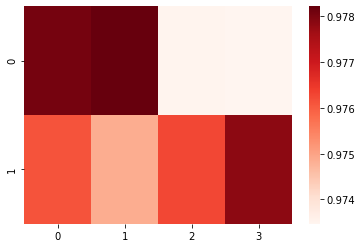

In [76]:
sns.heatmap(demand_met, cmap = "Reds")
plt.show()

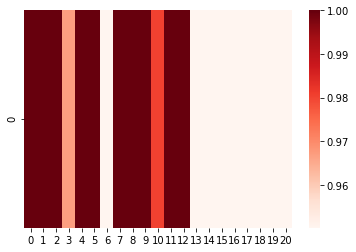

In [77]:
sns.heatmap([Scen_demand], cmap = "Reds")
plt.show()

## Connections between Nodes 

In [294]:
# Manufacturing Plant -> DC -> Market Zone

In [336]:
MP = ["I_" + str(i) for i in range(Manufacturing_plants)]
DC = ["J_" + str(j) for j in range(Distribution)]
MZ = ["K_" + str(k) for k in range(Market)]
Position_dic = {}
Node_colors = []
Edge_colors = []
Node_size = []
Weight = []
Weight_ij = []
Weight_jk = []
Max_p = max(Manufacturing_plants, Distribution, Market)

In [337]:
Y = grbModel.getAttr('x', Y_ijm)
Z = grbModel.getAttr('x', Z_jkm)

In [338]:
Y_mat = np.array(list(Y.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
Z_mat = np.array(list(Z.values())).reshape(num_Scenarios, Products, Distribution, Market)

In [339]:
Yij = sum(sum(Y_mat))/num_Scenarios

In [340]:
Zjk = sum(sum(Z_mat))/num_Scenarios

C:\Users\Devika Kabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:68: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


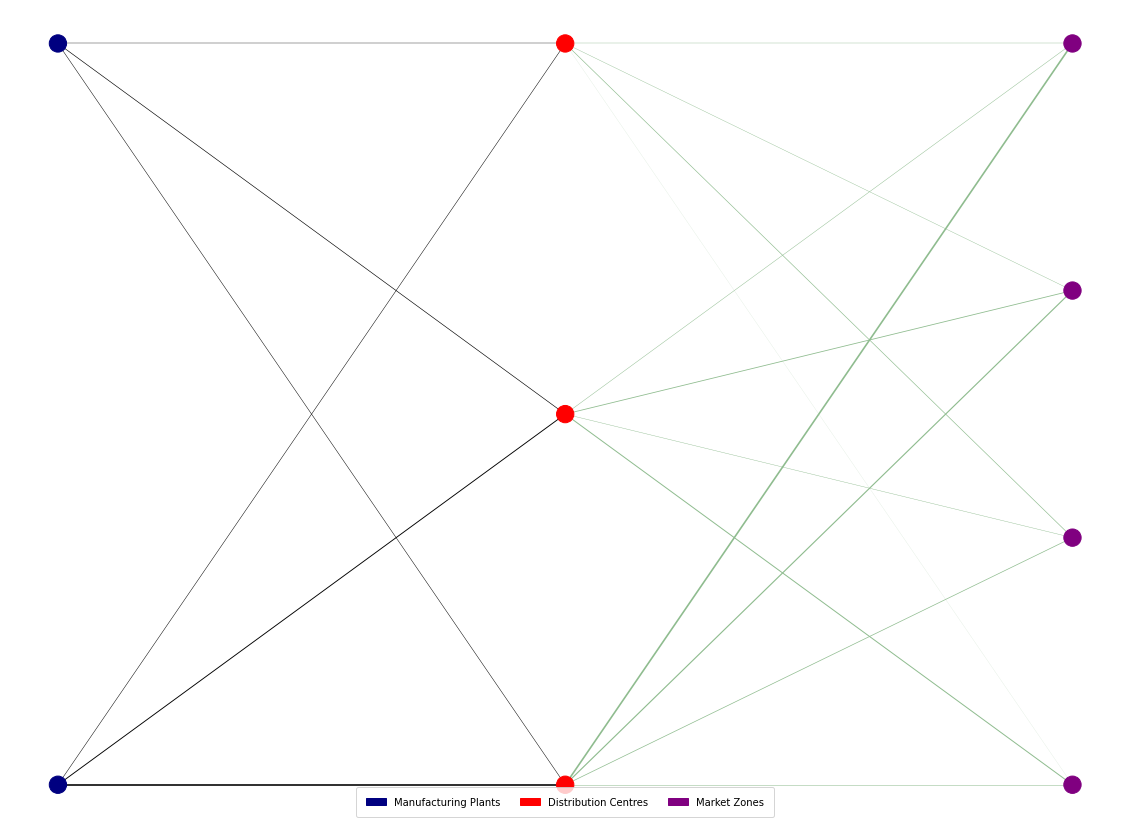

In [341]:
IJ_edges = []
for i in range(Manufacturing_plants):
    for j in range(Distribution):
        #if Yij[i][j] > 0:
        IJ_edges.append(("I_" + str(i), "J_" + str(j)))    
Weight_ij.extend(Yij.sum(axis=1))
    
JK_edges = []
for j in range(Distribution):
    for k in range(Market):
        #if Zjk[j][k] > 0:
        JK_edges.append(("J_" + str(j), "K_" + str(k)))
Weight_jk.extend(Zjk.sum(axis=1))
    
Weight.extend([3*Yij[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
Weight.extend([4*Zjk[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
            
Labels = []
Graph = nx.Graph()

Position_values = []
y_pos = np.linspace(0, Max_p, Manufacturing_plants)
for i in range(Manufacturing_plants):
    position = (0, y_pos[i])
    Graph.add_node(MP[i])
    Node_colors.append('navy')
    Labels.append("i" + str(i))
    Position_values.append(np.asarray(position))
Position_dic = dict(zip(MP, Position_values))

Position_values = []
y_pos = np.linspace(0, Max_p, Distribution)
for j in range(Distribution):
    position = (1, y_pos[j])
    Graph.add_node(DC[j])
    Node_colors.append('red')
    Labels.append("j" + str(j))
    Position_values.append(np.asarray(position))
Position_dic.update(dict(zip(DC, Position_values)))

Position_values = []
y_pos = np.linspace(0, Max_p, Market)
for k in range(Market):
    position = (2, y_pos[k])
    Graph.add_node(MZ[k])
    Node_colors.append('purple')
    Labels.append("k" + str(k))
    Position_values.append(np.asarray(position))
Position_dic.update(dict(zip(MZ, Position_values)))

# Add Edges

Graph.add_edges_from(IJ_edges)
Graph.add_edges_from(JK_edges)
Edge_colors.extend(['black' for i in IJ_edges])
Edge_colors.extend(['darkseagreen' for i in JK_edges])

nodePos = nx.shell_layout(Graph)
nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

limits=plt.axis('off')
plt.gcf().set_size_inches(20, 15)

lengend_mp = mpatches.Patch(color = 'navy', label = 'Manufacturing Plants')
lengend_dc = mpatches.Patch(color = 'red', label = 'Distribution Centres')
lengend_mz = mpatches.Patch(color = 'purple', label = 'Market Zones')

ax = plt.subplot(111)
ax.legend(loc = 'lower center', handles=[lengend_mp, lengend_dc, lengend_mz], ncol = 3, borderpad=1)

plt.show()

In [342]:
# Outsource -> DC

In [343]:
T1 = grbModel.getAttr('x', T_ljm)

In [344]:
T1_mat = np.array(list(T1.values())).reshape(num_Scenarios, Products, Outsourced, Distribution)

In [345]:
Tlj = sum(sum(T1_mat))/num_Scenarios

In [346]:
O = ["L_" + str(l) for l in range(Outsourced)]

In [347]:
Position_dic = {}
Node_colors = []
Edge_colors = []
Weight = []
Weight_lj = []
Max_p = max(Outsourced, Distribution)

C:\Users\Devika Kabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


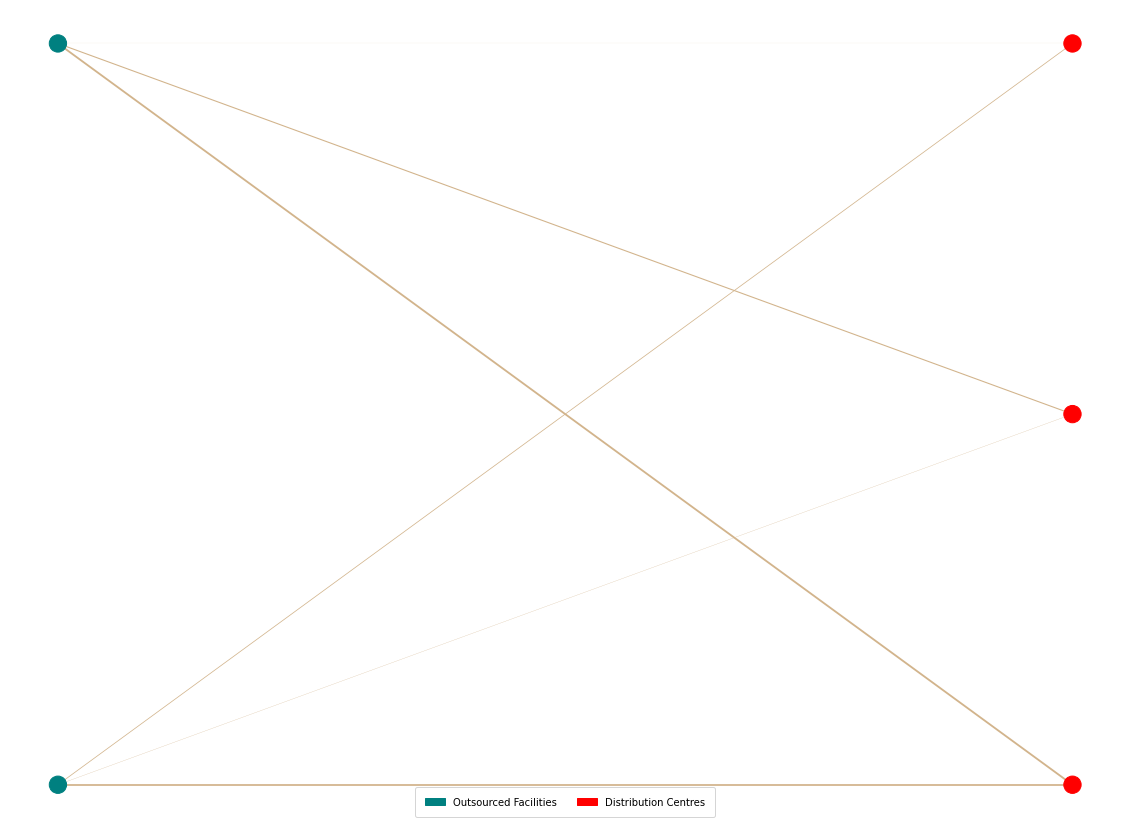

In [348]:
LJ_edges = []
for l in range(Outsourced):
    for j in range(Distribution):
        #if Tlj[l][j] > 0:
        LJ_edges.append(("L_" + str(l), "J_" + str(j)))    
Weight_lj.extend(Tlj.sum(axis = 1))

Weight.extend([3*Tlj[l][j]/max(Weight_lj) for l in range(Outsourced) for j in range(Distribution)])
            
Labels = []
Graph = nx.Graph()

Position_values = []
y_pos = np.linspace(0, Max_p, Outsourced)
for l in range(Outsourced):
    position = (0, y_pos[l])
    Graph.add_node(O[l])
    Node_colors.append('teal')
    Labels.append("l" + str(l))
    Position_values.append(np.asarray(position))
Position_dic = dict(zip(O, Position_values))

Position_values = []
y_pos = np.linspace(0, Max_p, Distribution)
for j in range(Distribution):
    position = (1, y_pos[j])
    Graph.add_node(DC[j])
    Node_colors.append('red')
    Labels.append("j" + str(j))
    Position_values.append(np.asarray(position))
Position_dic.update(dict(zip(DC, Position_values)))


# Add edges
Graph.add_edges_from(LJ_edges)
Edge_colors.extend(['tan' for l in LJ_edges])

nodePos = nx.shell_layout(Graph)
nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

limits=plt.axis('off')
plt.gcf().set_size_inches(20, 15)

lengend_o = mpatches.Patch(color = 'teal', label = 'Outsourced Facilities')
lengend_dc = mpatches.Patch(color = 'red', label = 'Distribution Centres')

ax = plt.subplot(111)
ax.legend(loc = 'lower center', handles=[lengend_o, lengend_dc], ncol = 2, borderpad=1)

plt.show()


In [349]:
# Outsource -> Market Zone

In [350]:
T2 = grbModel.getAttr('x', T_lkm)

In [351]:
T2_mat = np.array(list(T2.values())).reshape(num_Scenarios, Products, Outsourced, Market)

In [352]:
Tlk = sum(sum(T2_mat))/num_Scenarios

In [353]:
Position_dic = {}
Node_colors = []
Edge_colors = []
Weight = []
Weight_lk = []
Max_p = max(Outsourced, Market)

C:\Users\Devika Kabe\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


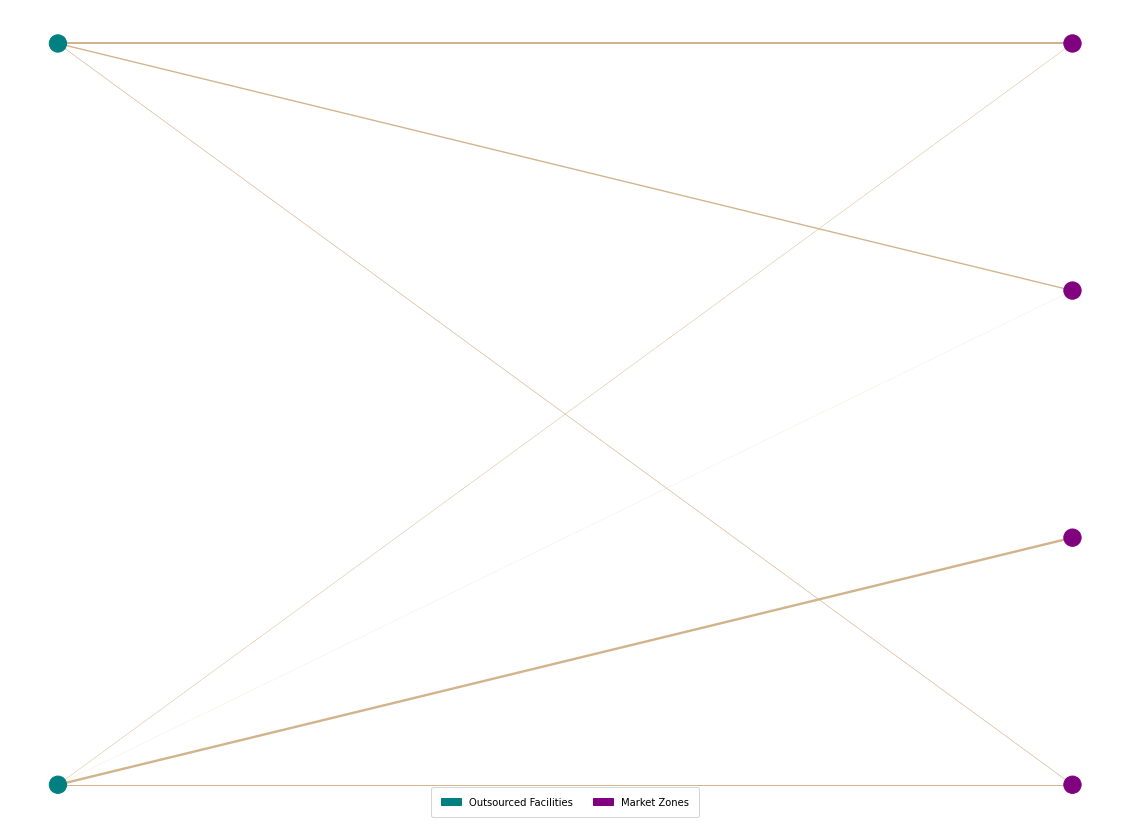

In [354]:
LK_edges = []
for l in range(Outsourced):
    for k in range(Market):
        #if Tlk[l][k] > 0:
        LK_edges.append(("L_" + str(l), "K_" + str(k)))    
Weight_lk.extend(Tlk.sum(axis = 1))

Weight.extend([4*Tlk[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])
            
Labels = []
Graph = nx.Graph()

Position_values = []
y_pos = np.linspace(0, Max_p, Outsourced)
for l in range(Outsourced):
    position = (0, y_pos[l])
    Graph.add_node(O[l])
    Node_colors.append('teal')
    Labels.append("l" + str(l))
    Position_values.append(np.asarray(position))
Position_dic = dict(zip(O, Position_values))

Position_values = []
y_pos = np.linspace(0, Max_p, Market)
for k in range(Market):
    position = (1, y_pos[k])
    Graph.add_node(MZ[k])
    Node_colors.append('purple')
    Labels.append("k" + str(k))
    Position_values.append(np.asarray(position))
Position_dic.update(dict(zip(MZ, Position_values)))


# Add edges
Graph.add_edges_from(LK_edges)
Edge_colors.extend(['tan' for l in LK_edges])

nodePos = nx.shell_layout(Graph)
nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

limits=plt.axis('off')
plt.gcf().set_size_inches(20, 15)

lengend_o = mpatches.Patch(color = 'teal', label = 'Outsourced Facilities')
lengend_dc = mpatches.Patch(color = 'purple', label = 'Market Zones')

ax = plt.subplot(111)
ax.legend(loc = 'lower center', handles=[lengend_o, lengend_dc], ncol = 2, borderpad=1)

plt.show()

## Comparing different weights for objective values 

In [355]:
dictionaries = []
for weights in weights_20:
    dictionary = {'f1': weights[0], 'f2': weights[1]}
    dictionaries.append(dictionary)

In [356]:
dictionaries

[{'f1': 0.0, 'f2': 1.0},
 {'f1': 0.05, 'f2': 0.95},
 {'f1': 0.1, 'f2': 0.9},
 {'f1': 0.15, 'f2': 0.85},
 {'f1': 0.2, 'f2': 0.8},
 {'f1': 0.25, 'f2': 0.75},
 {'f1': 0.3, 'f2': 0.7},
 {'f1': 0.35, 'f2': 0.65},
 {'f1': 0.4, 'f2': 0.6},
 {'f1': 0.45, 'f2': 0.55},
 {'f1': 0.5, 'f2': 0.5},
 {'f1': 0.55, 'f2': 0.45},
 {'f1': 0.6, 'f2': 0.4},
 {'f1': 0.65, 'f2': 0.35},
 {'f1': 0.7, 'f2': 0.3},
 {'f1': 0.75, 'f2': 0.25},
 {'f1': 0.8, 'f2': 0.2},
 {'f1': 0.85, 'f2': 0.15},
 {'f1': 0.9, 'f2': 0.1},
 {'f1': 0.95, 'f2': 0.05},
 {'f1': 1.0, 'f2': 0.0}]

In [357]:
## Configuration 1 
p = 0.4
rl = 0.99
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  144.14824645929926
obj val:  288.2964929185985
obj val:  432.4447393778971
obj val:  576.592985837197
obj val:  720.7412322964974
obj val:  864.8894787557942
obj val:  1009.0377252150929
obj val:  1153.185971674394
obj val:  1297.33421813369
obj val:  1441.4824645929948
obj val:  1585.6307110522876
obj val:  1729.7789575115887
obj val:  1874.3241168271675
obj val:  2080.405827306311
obj val:  2168.5175978002385
obj val:  2260.6149920494354
obj val:  2358.444475104119
obj val:  2444.291505749311
obj val:  2508.2851376703657
obj val:  2564.7928491263156


In [358]:
df_1 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_1

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,11484.81,0.0,2.0,3.0
1,0.05,0.95,2883.10,0.0,2.0,3.0
2,0.10,0.90,2883.10,0.0,2.0,3.0
3,0.15,0.85,2883.10,0.0,2.0,3.0
4,0.20,0.80,2883.10,0.0,2.0,3.0
5,0.25,0.75,2883.10,0.0,2.0,3.0
6,0.30,0.70,2883.10,0.0,2.0,3.0
7,0.35,0.65,2883.10,0.0,2.0,3.0
8,0.40,0.60,2883.10,0.0,2.0,3.0
9,0.45,0.55,2883.14,0.0,2.0,3.0


In [359]:
f2_1 = list(df_1['f2'])
f1_1 = list(df_1['f1'])

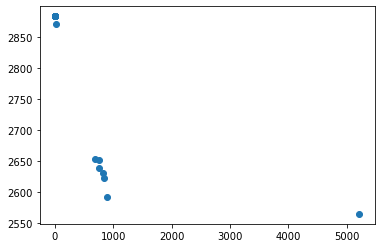

In [361]:
plt.scatter(f2_1[1:], f1_1[1:])
plt.show()

In [213]:
## Configuration 2 
p = 0.2
rl = 0.9
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  457.2980092685126
obj val:  914.5960185370252
obj val:  927.8187727138263
obj val:  1092.3264384885847
obj val:  1266.0400335270324
obj val:  1468.4632430867894
obj val:  1661.0122243943265
obj val:  2052.1559202920307
obj val:  2403.5682557041114
obj val:  2725.9203976555336
obj val:  3046.960930244659
obj val:  3437.1005883993275
obj val:  4142.819160151441
obj val:  4613.842536712903
obj val:  3840.089801095065
obj val:  2541.4157021956858
obj val:  2503.2255509821125
obj val:  2554.026566275243
obj val:  2532.0970488934304
obj val:  2596.746789627761


In [214]:
df_2 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_2

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,28833.00,0.0,2.0,3.0
1,0.05,0.95,9145.89,0.0,2.0,3.0
2,0.10,0.90,9145.89,0.0,2.0,3.0
3,0.15,0.85,4277.79,337.0,2.0,3.0
4,0.20,0.80,3976.81,371.0,2.0,3.0
5,0.25,0.75,3947.84,372.0,2.0,3.0
6,0.30,0.70,4026.63,372.0,2.0,3.0
7,0.35,0.65,4052.06,374.0,2.0,3.0
8,0.40,0.60,4485.20,430.0,2.0,3.0
9,0.45,0.55,4776.74,462.0,2.0,3.0


In [216]:
f2_2 = list(df_2['f2'])
f1_2 = list(df_2['f1'])

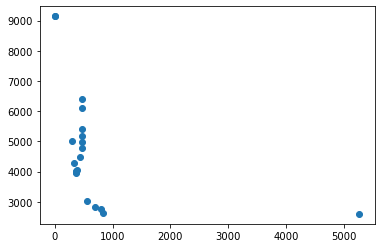

In [217]:
plt.scatter(f2_2[1:],f1_2[1:])
plt.show()

In [631]:
## Configuration 3
p = 0.2
rl = 0.85
objective_vals = []
for Dict in dictionaries:
    run_Model(p, rl, Dict)
    objective_vals.append([Dict['f1'], Dict['f2'], Cost_dict['f1'], Cost_dict['f2'], Summary_dict["OpenMPs"], Summary_dict["OpenDCs"]])

obj val:  0.0
obj val:  307.76508132805424
obj val:  512.2126353277971
obj val:  648.8225191109751
obj val:  777.0490731003479
obj val:  900.6404968286259
obj val:  1022.3305009562547
obj val:  1143.9513031715767
obj val:  1265.269415146225
obj val:  1386.464213909402
obj val:  1507.290230922689
obj val:  1627.7114244573838
obj val:  1747.7176961408838
obj val:  1867.1639163800799
obj val:  1985.6267863782284
obj val:  2103.877748617751
obj val:  2222.386212644649
obj val:  2328.293148779636
obj val:  2415.358866156299
obj val:  2488.156457033179
obj val:  2546.144583293276


In [632]:
df_3 = pd.DataFrame((objective_vals), columns = ["f1 weight", "f2 weight", "f1", "f2", "Plants", "DCs"])
df_3

,f1 weight,f2 weight,f1,f2,Plants,DCs
0,0.00,1.00,147556.95,0.0,2.0,3.0
1,0.05,0.95,6155.17,0.0,2.0,3.0
2,0.10,0.90,2973.71,253.0,2.0,3.0
3,0.15,0.85,2828.64,279.0,2.0,3.0
4,0.20,0.80,2828.68,279.0,2.0,3.0
5,0.25,0.75,2726.00,310.0,2.0,3.0
6,0.30,0.70,2726.00,310.0,2.0,3.0
7,0.35,0.65,2722.10,310.0,2.0,3.0
8,0.40,0.60,2720.24,304.0,2.0,3.0
9,0.45,0.55,2715.33,304.0,2.0,3.0


In [636]:
f2_3 = list(df_3['f2'])
f1_3 = list(df_3['f1'])

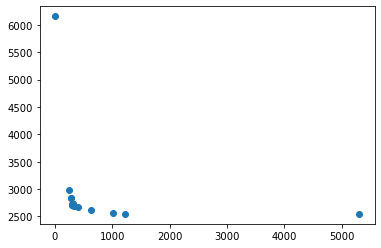

In [681]:
plt.scatter(f2_3[1:], f1_3[1:])
plt.show()

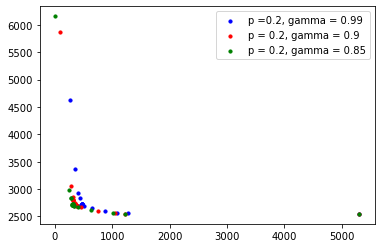

In [638]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(f2_1[1:], f1_1[1:], s=10, c='b', marker="o", label='p =0.2, gamma = 0.99')
ax1.scatter(f2_2[1:], f1_2[1:], s=10, c='r', marker="o", label='p = 0.2, gamma = 0.9')
ax1.scatter(f2_3[1:], f1_3[1:], s=10, c='g', marker="o", label='p = 0.2, gamma = 0.85')

plt.legend(loc='upper right');
plt.show()

In [150]:
Yij.sum(axis=1)

array([120.84886035,  59.74492599])